In [631]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

## Load Dataset

In [633]:
#load preprocessed dataset
data = pd.read_csv('./data/processed_text.csv')
data.head()

,post_id,title,created_utc,subreddit,comments,title_length,processed_title,processed_comments,processed_text,comments_length
0,1fzfb8t,Will Trump or Kamala Harris win key swing stat...,2024-10-09 00:45:16,technology,['I asked AI how to clean a cast iron pan and ...,72,trump kamala harris win key swing state ask ch...,ask ai clean cast iron pan tell mix bleach amm...,trump kamala harris win key swing state ask ch...,85
1,1fyxmo4,Nobel Prize in physics awarded to 2 scientists...,2024-10-08 11:37:11,technology,[],99,nobel prize physics award scientist discovery ...,NaN,nobel prize physics award scientist discovery ...,2
2,1fz0m72,Adobe has a new tool to protect artists’ work ...,2024-10-08 14:05:54,technology,"['The irony... Adobe stole from, pardon ""opted...",53,adobe new tool protect artist work ai,irony adobe steal pardon opt creative datum gr...,adobe new tool protect artist work ai irony ad...,560
3,1fc2c3m,Stellantis And Tesla Hit Rock Bottom In CR’s U...,2024-09-08 16:50:16,technology,['How can Stellantis (Chrysler/Jeep/Ram) hit r...,80,stellantis tesla hit rock crs car brand reliab...,stellantis chryslerjeepram hit rock rock delete,stellantis tesla hit rock crs car brand reliab...,105
4,1fc2ufg,Analysis of thousands of channels reveals Tele...,2024-09-08 17:12:16,technology,"['Funny part, these days Telegram is the only ...",85,analysis thousand channel reveal telegram floo...,funny day telegram widely message platform end...,analysis thousand channel reveal telegram floo...,270


### Model Preparation

In [635]:
# Define X and y.
#X = data['processed_text']
X = data['processed_text']
y = data['subreddit']

### Train Test Split

In [637]:
# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


### Baseline Accuracy

In [639]:
y.value_counts(normalize = True)

subreddit
technology    0.619191
gadgets       0.380809
Name: proportion, dtype: float64

### Model 1: Count Vectorization with Logistic Regression

In [641]:
logr_pipe = Pipeline(
    [
        ('cvec',CountVectorizer()),
        ('logr',LogisticRegression())
    ]
)

grid_params = {
    'cvec__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'cvec__max_df': [0.75, 0.85, 1.0],      # Ignore very frequent words
    'cvec__min_df': [1, 2, 5],              # Ignore very infrequent words
    'cvec__max_features': [None, 5000, 10000],  # Limit on the number of features

    'logr__C': [0.01, 0.1, 1.0, 10],        # Regularization strength
    'logr__penalty': ['l2'],                # L2 regularization (Ridge)
    'logr__solver': ['lbfgs', 'liblinear']  # Solvers suitable for small datasets
}


gs_logr = GridSearchCV(logr_pipe,grid_params,n_jobs=-1)
gs_logr.fit(X_train,y_train)
print(f' Best parameters:{gs_logr.best_params_}')
print(f' Best score:{gs_logr.best_score_}')

 Best parameters:{'cvec__max_df': 0.75, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'logr__C': 10, 'logr__penalty': 'l2', 'logr__solver': 'liblinear'}
 Best score:0.8466834271274504


In [642]:
###Logistic Regression Coefficients 
print(f"Logistic Regression Coefficients: {gs_logr.best_estimator_.named_steps['logr'].coef_}")
print(f"Logistic Regression Intercept: {gs_logr.best_estimator_.named_steps['logr'].intercept_}")


Logistic Regression Coefficients: [[-1.45591471e-01 -1.45638079e-01  4.66082383e-05 ... -1.90174770e-02
   1.69779253e-07  1.69779253e-07]]
Logistic Regression Intercept: [0.50765203]


### Model Evaluation

In [644]:
preds = gs_logr.predict(X_test)

train_accuracy = round(gs_logr.score(X_train, y_train), 2)
test_accuracy = round(gs_logr.score(X_test, y_test), 2)

train_misclassification_rate = round(1 - train_accuracy, 2)
test_misclassification_rate = round(1 - test_accuracy, 2)

print(f'Training Accuracy of Logistic Regression with Count Vectorizer: {train_accuracy}')
print(f'Testing Accuracy of Logistic Regression with Count Vectorizer: {test_accuracy}')

print(f'Training Misclassification Rate: {train_misclassification_rate}')
print(f'Testing Misclassification Rate: {test_misclassification_rate}')

Training Accuracy of Logistic Regression with Count Vectorizer: 1.0
Testing Accuracy of Logistic Regression with Count Vectorizer: 0.84
Training Misclassification Rate: 0.0
Testing Misclassification Rate: 0.16


In [645]:

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

logr_spec = tn / (tn + fp)
print(f'Logistic Regression specificity: {round(logr_spec,2)}')
# recall

recall = tp / (tp + fn)

print(f'Logistic Regression recall: {round(recall,2)}')

Logistic Regression specificity: 0.75
Logistic Regression recall: 0.89


In [646]:
#classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

     gadgets       0.81      0.75      0.78       791
  technology       0.85      0.89      0.87      1286

    accuracy                           0.84      2077
   macro avg       0.83      0.82      0.83      2077
weighted avg       0.84      0.84      0.84      2077



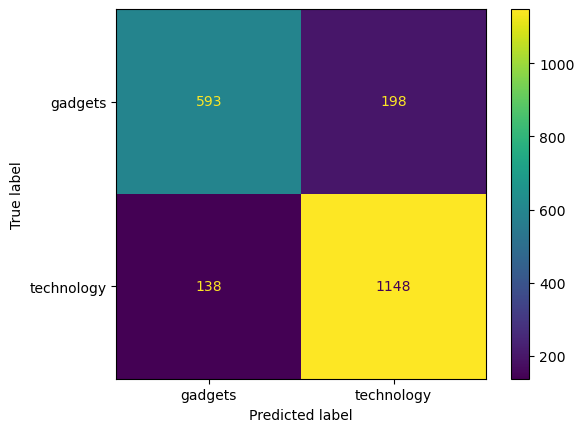

In [647]:
ConfusionMatrixDisplay.from_estimator(gs_logr,X_test,y_test);

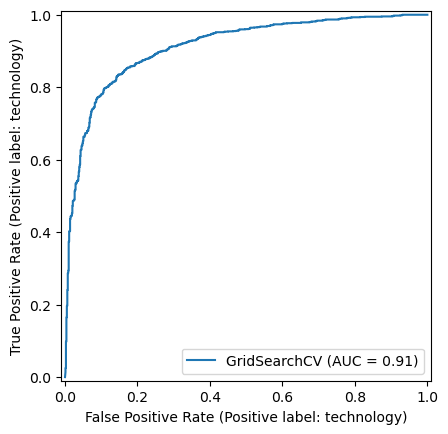

In [648]:
RocCurveDisplay.from_estimator(gs_logr,X_test,y_test);

### Model 2: TF-IDF Vectorization with KNN 

In [650]:
knn_pipe= Pipeline(
    [
        ('tf-idf',TfidfVectorizer()),
        ('knn',KNeighborsClassifier())
    ]
)
grid_params={
    'tf-idf__stop_words': [None, 'english'],
    'tf-idf__max_features': range(2000, 4001, 1000),
    'tf-idf__min_df': [2, 4],
    'tf-idf__max_df': np.linspace(0.9, 0.99, 5),
    'knn__n_neighbors': range(3, 12, 2)
}
gs_knn = GridSearchCV(knn_pipe,grid_params,n_jobs=-1)
gs_knn.fit(X_train,y_train)
print(f' Best parameters:{gs_knn.best_params_}')
print(f' Best score:{gs_knn.best_score_}')

 Best parameters:{'knn__n_neighbors': 11, 'tf-idf__max_df': 0.9, 'tf-idf__max_features': 4000, 'tf-idf__min_df': 4, 'tf-idf__stop_words': 'english'}
 Best score:0.8392991548859967


/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Model Evaluation

In [652]:
pred = gs_knn.predict(X_test)

train_accuracy = round(gs_knn.score(X_train, y_train), 2)
test_accuracy = round(gs_knn.score(X_test, y_test), 2)

train_misclassification_rate = round(1 - train_accuracy, 2)
test_misclassification_rate = round(1 - test_accuracy, 2)

print(f'Training Accuracy of Logistic Regression with Count Vectorizer: {train_accuracy}')
print(f'Testing Accuracy of Logistic Regression with Count Vectorizer: {test_accuracy}')

print(f'Training Misclassification Rate: {train_misclassification_rate}')
print(f'Testing Misclassification Rate: {test_misclassification_rate}')

Training Accuracy of Logistic Regression with Count Vectorizer: 0.88
Testing Accuracy of Logistic Regression with Count Vectorizer: 0.84
Training Misclassification Rate: 0.12
Testing Misclassification Rate: 0.16


In [653]:

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

knn_spec = tn / (tn + fp)
print(f'KNN specificity: {round(knn_spec,2)}')
# recall

recall = tp / (tp + fn)

print(f'KNN recall: {round(recall,2)}')

KNN specificity: 0.83
KNN recall: 0.85


In [654]:
#classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     gadgets       0.77      0.83      0.80       791
  technology       0.89      0.85      0.87      1286

    accuracy                           0.84      2077
   macro avg       0.83      0.84      0.83      2077
weighted avg       0.85      0.84      0.84      2077



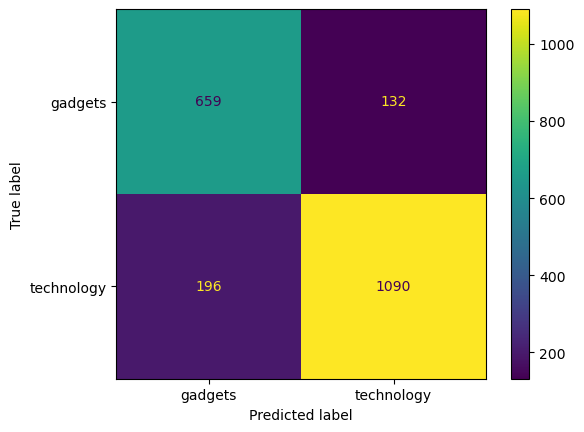

In [655]:
ConfusionMatrixDisplay.from_estimator(gs_knn,X_test,y_test);

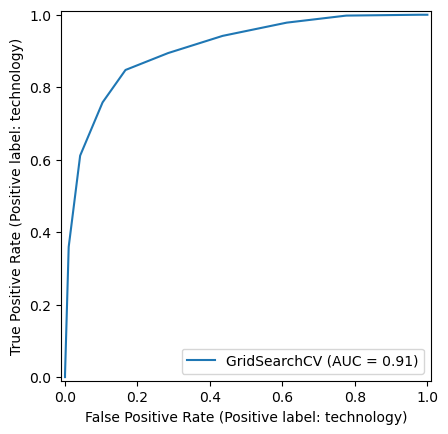

In [656]:
RocCurveDisplay.from_estimator(gs_knn,X_test,y_test);

In [657]:
### Model 3: Spacy vectors with Naive Bayes

In [658]:
pipe_nb =Pipeline(
    [
        ('cvec',CountVectorizer()),
        ('nb',MultinomialNB())
    ]
)


grid_params = {
    'cvec__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'cvec__max_df': [0.75, 0.85],           # Ignore very frequent words
    'cvec__min_df': [1, 2],                 # Ignore infrequent words
    'nb__alpha': [0.1, 0.5, 1.0]            # Smoothing parameter for Naive Bayes
}

gs_nb = GridSearchCV(pipe_nb, grid_params, n_jobs=-1, cv=5)
gs_nb.fit(X_train, y_train)

print(f' Best parameters:{gs_nb.best_params_}')
print(f' Best score:{gs_nb.best_score_}')

 Best parameters:{'cvec__max_df': 0.75, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'nb__alpha': 1.0}
 Best score:0.8632192977366933


### Model Evaluation

In [660]:
pred = gs_nb.predict(X_test)

train_accuracy = round(gs_nb.score(X_train, y_train), 2)
test_accuracy = round(gs_nb.score(X_test, y_test), 2)

train_misclassification_rate = round(1 - train_accuracy, 2)
test_misclassification_rate = round(1 - test_accuracy, 2)

print(f'Training Accuracy of Naive bayes  with Count Vectorizer: {train_accuracy}')
print(f'Testing Accuracy of Naive bayes  with Count Vectorizer: {test_accuracy}')

print(f'Training Misclassification Rate: {train_misclassification_rate}')
print(f'Testing Misclassification Rate: {test_misclassification_rate}')


Training Accuracy of Naive bayes  with Count Vectorizer: 0.91
Testing Accuracy of Naive bayes  with Count Vectorizer: 0.85
Training Misclassification Rate: 0.09
Testing Misclassification Rate: 0.15


In [661]:
# Perform cross-validation on the entire training data using the final model
cross_val_scores = cross_val_score(gs_nb.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)

# Calculate the mean cross-validation score
mean_cross_val_score = cross_val_scores.mean()
mean_cross_val_score

0.8632192977366933

In [662]:

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

knn_spec = tn / (tn + fp)
print(f'Naive Bayes specificity: {round(knn_spec,2)}')
# recall

recall = tp / (tp + fn)

print(f'Naive Bayes recall: {round(recall,2)}')

Naive Bayes specificity: 0.82
Naive Bayes recall: 0.87


In [663]:
#classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     gadgets       0.80      0.82      0.81       791
  technology       0.89      0.87      0.88      1286

    accuracy                           0.85      2077
   macro avg       0.84      0.85      0.84      2077
weighted avg       0.85      0.85      0.85      2077



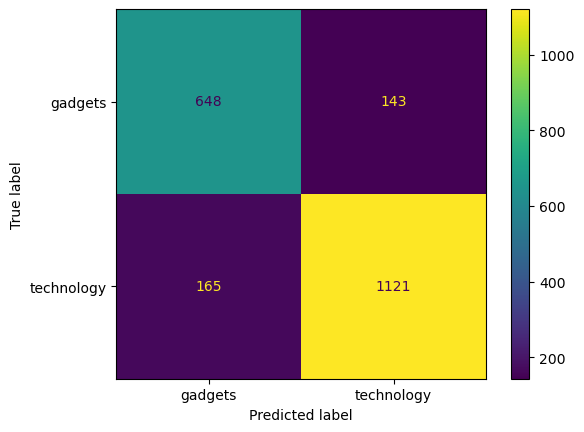

In [664]:
ConfusionMatrixDisplay.from_estimator(gs_nb,X_test,y_test);

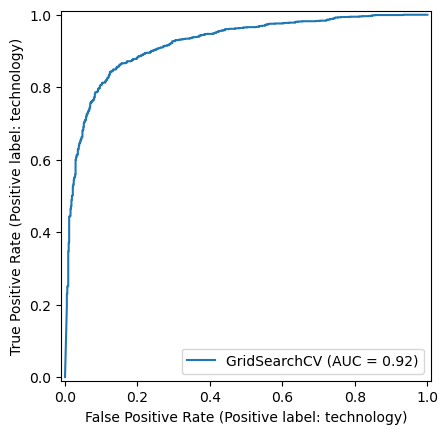

In [665]:
RocCurveDisplay.from_estimator(gs_nb,X_test,y_test);

In [666]:
# Import required libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd

# Load preprocessed dataset
file_path = './data/processed_text.csv'  # Update with the correct path to your file
df = pd.read_csv(file_path)

# Define features (X) and labels (y)
X = df['processed_text']
y = df['subreddit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Use the best parameters from the RandomizedSearchCV to create a final model
best_params = {
    'cvec__max_df': 0.75,
    'cvec__min_df': 2,
    'cvec__ngram_range': (1, 1),
    'nb__alpha': 1.0
}

# Create the CountVectorizer with the best parameters
final_cvec = CountVectorizer(max_df=best_params['cvec__max_df'],
                             min_df=best_params['cvec__min_df'],
                             ngram_range=best_params['cvec__ngram_range'])

# Define base learners for stacking
base_learners = [
    ('nb', MultinomialNB(alpha=1.0)),  # Naive Bayes with best alpha
    ('logr', LogisticRegression(max_iter=1000, random_state=42)),  # Logistic Regression
    ('svm', SVC(probability=True, random_state=42))  # Support Vector Machine
]

# Define meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, n_jobs=-1)

# Fit CountVectorizer on the training data
X_train_cvec = final_cvec.fit_transform(X_train)

# Fit the stacking model on the transformed training data
stacking_clf.fit(X_train_cvec, y_train)

# Evaluate the stacking model on the training and test data
X_test_cvec = final_cvec.transform(X_test)
stacking_training_accuracy = stacking_clf.score(X_train_cvec, y_train)
stacking_test_accuracy = stacking_clf.score(X_test_cvec, y_test)

# Display the training and test accuracy of the stacking model
print(f'Training Accuracy: {stacking_training_accuracy}')
print(f'Test Accuracy: {stacking_test_accuracy}')


Training Accuracy: 0.9473684210526315
Test Accuracy: 0.85553772070626
